## Plot Energi Kumulatif dan RSAM v1.0

Gunakan cell di bawah untuk mengeplot energi kumulatif yang dioverlay RSAM

________________________________
file RSAM :
202505_VG_MLLR_EHZRSAM10Min.DAT


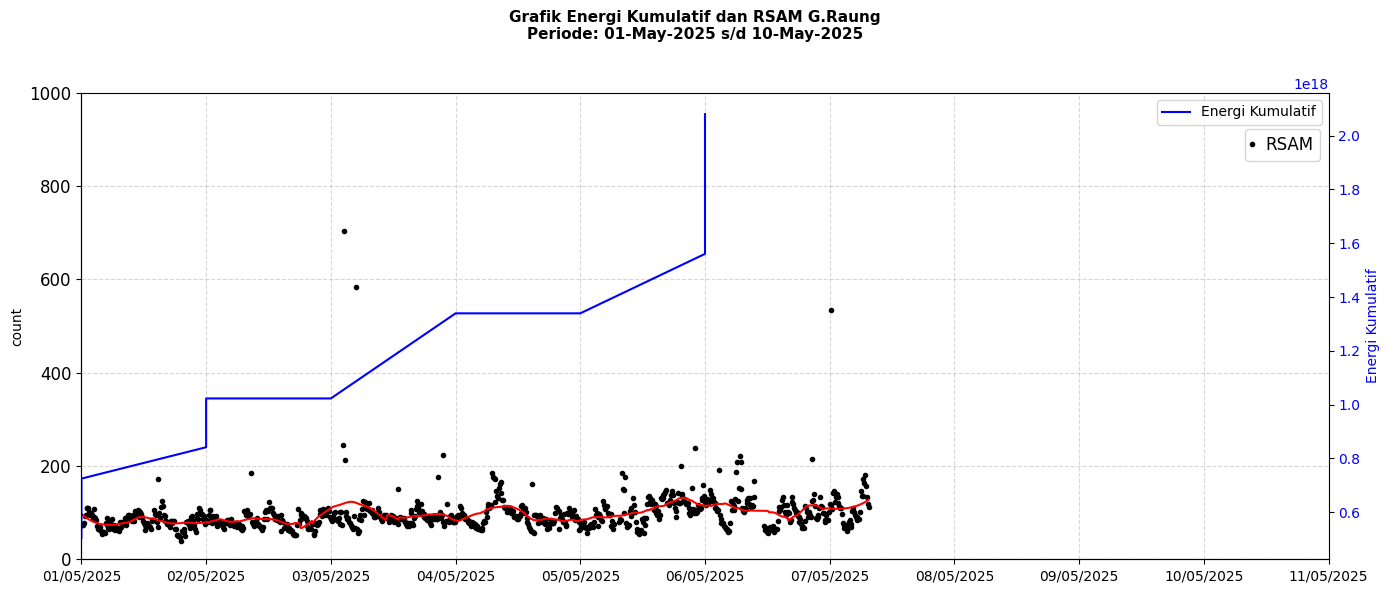

________________________________
Data Gempa


,Tanggal,Waktu tiba,Amplituda,S-P,Durasi,Magnitudo,Energi,Energi kumulatif,Type gempa
0,2025-05-01,01:03:22,10,1.5,20,3.934967,504023676128412992,504023676128412992,Tektonik Lokal
1,2025-05-01,02:03:00,5,1.1,15,3.696334,221055567339622016,725079243468034944,Vulkanik Dalam
2,2025-05-02,13:10:55,7,1.6,12,3.511236,116641815289838000,841721058757873024,Vulkanik Dalam
3,2025-05-02,15:05:06,3,1.5,14,3.639105,181408161614088000,1023129220371960064,Vulkanik Dalam
5,2025-05-04,02:06:17,4,1.8,17,3.800157,316399770454625024,1339528990826589952,Tektonik Lokal
7,2025-05-06,17:18:03,8,2.1,15,3.696334,221055567339622016,1560584558166210048,Tektonik Lokal
8,2025-05-06,18:19:22,6,1.2,13,3.577632,146705942007180000,1707290500173390080,Vulkanik Dalam
9,2025-05-06,21:06:15,5,2.3,18,3.847570,372696854264420992,2079987354437809920,Tektonik Lokal


In [6]:
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
from scipy.signal import savgol_filter

# Tentukan tanggal awal, tanggal akhir, dan interval axis
waktu_awal = '01-05-2025'
waktu_akhir = '10-05-2025'
interval_hari = 1

# Definisikan nama gunung dan path data logbook gempa
gunung = "Raung"
path_file = "D:/Mukijo/logbook-vt.xlsx"

# Baris untuk diabaikan
baris_diabaikan = 2

# Axis y jumlah gempa
min_jumlah = 0
max_jumlah = 10
interval_jumlah = 2

# Definisikan path folder data RSAM
directory = r"//192.189.22.130/data/Rsam/10Minute"
stasiun = "MLLR"

nilai_maks_axis_rsam = 1000
interval_axis_rsam = 200

# Mengambil nilai bulan dan tahun
start_year = int(waktu_awal[6:])
start_month = int(waktu_awal[3:5])
end_year = int(waktu_akhir[6:])
end_month = int(waktu_akhir[3:5])

tanggal_awal = pd.to_datetime(waktu_awal, format='%d-%m-%Y')
tanggal_akhir = pd.to_datetime(waktu_akhir, format='%d-%m-%Y')

# Proses menggabungkan file-file 
# Nama file harus memiliki format standar earthworm, yaitu "yyyymm_network_station_componentRSAM10Min.DAT", contoh "202401_VG_MLLR_EHZRSAM10Min.DAT"
merged_data = pd.DataFrame()
files_to_merge = []  
for filename in os.listdir(directory):
    if filename.endswith(".DAT"):
        # Membaca nama file
        try:
            year = int(filename[:4])
            month = int(filename[4:6])
            channel_name = filename[10:14]
        except ValueError:
            # Skip file jika tidak dapat di-parse sebagai angka untuk tahun dan bulan
            continue
        # Memeriksa apakah file cocok dengan kriteria sesuai nama stasiun, waktu awal, dan waktu akhir yang ditentukan sebelumnya
        if (start_year < end_year):
            if ((year == start_year and month >= start_month) or (year == end_year and month <= end_month) or (year > start_year and year < end_year)) and channel_name == stasiun:
                files_to_merge.append(filename)  # Menambahkan nama file ke daftar
                # Membaca file dan menggabungkannya
                filepath = os.path.join(directory, filename)
                data = pd.read_csv(filepath, sep=',', header=None, names=['Time', 'RSAM'])
                merged_data = pd.concat([merged_data, data], ignore_index=True)
        else:
            if (year == start_year and month >= start_month and year == end_year and month <= end_month) and channel_name == stasiun:
                files_to_merge.append(filename)  # Menambahkan nama file ke daftar
                # Membaca file dan menggabungkannya
                filepath = os.path.join(directory, filename)
                data = pd.read_csv(filepath, sep=',', header=None, names=['Time', 'RSAM'])
                merged_data = pd.concat([merged_data, data], ignore_index=True)

merged_data['Time'] = pd.to_datetime(merged_data['Time'], format='%d-%b-%Y %H:%M:%S')
data_rsam_filtered = merged_data[(merged_data['Time'] >= tanggal_awal) & (merged_data['Time'] <= tanggal_akhir + pd.Timedelta(days=1))]

print("________________________________")
print('file RSAM :')
for item in files_to_merge:
    print(item)


data_gempa = pd.read_excel(path_file, skiprows=baris_diabaikan)
data_gempa = data_gempa.ffill()
data_gempa['Tanggal'] = pd.to_datetime(data_gempa['Tanggal'], unit='D', origin='1899-12-30')

nan_columns = ['Gerak awal', 'Frekuensi', 'Type gempa']

# Isi tanggal kosong dan buat baris dummy
new_rows = []
for i in range(1, len(data_gempa)):
    prev_time = data_gempa.iloc[i - 1]['Tanggal']
    curr_time = data_gempa.iloc[i]['Tanggal']
    time_diff = curr_time - prev_time

    if time_diff > pd.Timedelta(days=1):
        new_time = prev_time + pd.Timedelta(days=1)
        energi_sebelumnya = data_gempa.iloc[i - 1]['Energi kumulatif']
        while new_time < curr_time:
            new_row = []
            for col in data_gempa.columns:
                if col == 'Tanggal':
                    new_row.append(new_time)
                elif col == 'Waktu tiba':
                    new_row.append(pd.to_datetime('00:00:00').time())
                elif col in nan_columns:
                    new_row.append(np.nan)
                elif col == 'Energi kumulatif':
                    new_row.append(energi_sebelumnya)
                else:
                    new_row.append(0)
            new_rows.append(new_row)
            new_time += pd.Timedelta(days=1)

if new_rows:
    new_df = pd.DataFrame(new_rows, columns=data_gempa.columns)
    data_gempa = pd.concat([data_gempa, new_df], ignore_index=True)
    
# Gabungkan kolom Tanggal dan Waktu tiba
data_gempa = data_gempa.sort_values(by='Tanggal').reset_index(drop=True)
data_gempa['waktu_delta'] = data_gempa['Waktu tiba'].apply(lambda x: pd.Timedelta(hours=x.hour, minutes=x.minute, seconds=x.second))
data_gempa['dateTime'] = data_gempa['Tanggal'] + data_gempa['waktu_delta']
data_gempa = data_gempa.drop(columns=['waktu_delta'])
data_gempa.insert(2, 'dateTime', data_gempa.pop('dateTime'))
data_gempa['dateTime'] = data_gempa['dateTime'].astype('int64')
data_gempa['dateTime'] = data_gempa['dateTime'].interpolate(method='linear')
data_gempa['dateTime'] = pd.to_datetime(data_gempa['dateTime'])
data_gempa['Energi_kumulatif'] = data_gempa['Energi'].cumsum()

# Filter baris dengan 'Type gempa' yang tidak kosong
data_gempa_filtered = data_gempa[~data_gempa['Type gempa'].isna()]
data_gempa_filtered = data_gempa_filtered[data_gempa_filtered['Type gempa'].isin(['Vulkanik Dalam', 'Tektonik Lokal'])]
gempa_per_day = data_gempa_filtered.groupby([data_gempa_filtered['Tanggal'].dt.date, 'Type gempa']).size().unstack(fill_value=0)

# Buat figure dan axis utama
# Plot energi kumulatif
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot data rsam di subplot pertama (axes[0])
ax1.grid(True, linestyle='--', alpha=0.5)
ax1.plot(data_rsam_filtered['Time'], data_rsam_filtered['RSAM'], label='RSAM', marker='.', linestyle='', color='black')
ax1.tick_params(axis='y', labelsize=12)

# Mengatur label x-axis di subplot pertama
ax1.tick_params(axis='x')
ax1.set_xlim(tanggal_awal, tanggal_akhir + pd.Timedelta(days=1))
date_format = mdates.DateFormatter('%d/%m/%Y')
ax1.xaxis.set_major_formatter(date_format)
ax1.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=[1, 15]))
ax1.set_xticklabels([])
ax1.set_ylim(0, nilai_maks_axis_rsam)
ax1.yaxis.set_major_locator(MultipleLocator(interval_axis_rsam))
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_ylabel('count')
ax1.legend(loc='upper right', frameon=True, fontsize=12, handlelength=0, bbox_to_anchor=(1, 0.94)) 

# Savitzky-Golay smoothing (garis tren)
window_size = 100  # Panjang jendela smoothing
degree = 3        # Derajat polinomial
smoothed_data = savgol_filter(data_rsam_filtered['RSAM'], window_size, degree)
ax1.plot(data_rsam_filtered['Time'], smoothed_data, linestyle='-', color='red')

ax2 = ax1.twinx()
ax2.plot(data_gempa['Tanggal'], data_gempa['Energi_kumulatif'], color='blue', label='Energi Kumulatif')
ax2.set_ylabel('Energi Kumulatif', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
days = mdates.DayLocator(interval=interval_hari)
ax2.xaxis.set_major_locator(days)
ax2.tick_params(axis='x', rotation=90)
date_format = mdates.DateFormatter('%d/%m/%Y')
ax2.xaxis.set_major_formatter(date_format)
start_time = datetime.strptime(waktu_awal, '%d-%m-%Y')
end_time = datetime.strptime(waktu_akhir, '%d-%m-%Y')
ax2.set_xlim([start_time, end_time + timedelta(days=1)])
ax2.legend(loc='upper right')

# Fungsi background jika diperlukan
def normal(start, end):
    plt.axvspan(start, end, facecolor='lime', alpha=0.35)

def waspada(start, end):
    plt.axvspan(start, end, facecolor='yellow', alpha=0.45)

def siaga(start, end):
    plt.axvspan(start, end, facecolor='orange', alpha=0.5)

def awas(start, end):
    plt.axvspan(start, end, facecolor='red', alpha=0.55)

# Memberi warna background sesuai status, ganti tanggal perubahan status sesuai histori, hapus/comment baris yang tidak perlu
# normal(pd.to_datetime('01/02/2025', format='%d/%m/%Y'), pd.to_datetime('28/02/2025', format='%d/%m/%Y'))
# waspada(pd.to_datetime('01/03/2025', format='%d/%m/%Y'), pd.to_datetime('31/04/2025', format='%d/%m/%Y'))
# siaga(pd.to_datetime('19/05/2023', format='%d/%m/%Y'), pd.to_datetime('31/08/2023', format='%d/%m/%Y'))
# awas(pd.to_datetime('21/07/2023', format='%d/%m/%Y'), pd.to_datetime('31/07/2023', format='%d/%m/%Y'))

# Judul
judul_grafik = f'Grafik Energi Kumulatif dan RSAM G.{gunung}'
periode = f'Periode: {tanggal_awal.strftime("%d-%b-%Y")} s/d {tanggal_akhir.strftime("%d-%b-%Y")}'
plt.suptitle(f"{judul_grafik}\n{periode}\n", fontsize=11, fontweight='bold', ha='center')

fig.tight_layout()
plt.show()

print("________________________________")
print("Data Gempa")
data_gempa_filtered[["Tanggal", "Waktu tiba", "Amplituda", "S-P", "Durasi", "Magnitudo", "Energi", "Energi kumulatif", "Type gempa"]]



Contoh format data logbook gempa:
https://docs.google.com/spreadsheets/d/1QrbC9U74uFvg-JJViCV9ESqKmRGMtwS7/edit?usp=sharing&ouid=101853471940845236138&rtpof=true&sd=true

Jumlah dan urutan kolom dalam tabel tidak harus sama, namun penamaan header kolom yang bersesuaian harus sama dengan contoh. Penamaan type gempa harus 'Vulkanik Dalam' untuk gempa Vulkanik dalam dan 'Tektonik Lokal' untuk gempa Tektonik lokal. Format tanggal dd/mm/yyyy dan format jam hh:mm:ss.